In [1]:
import sys
import numpy as np
import glob
import os
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as ss
import seaborn as sns
import pandas as pd
import dm_utils
import pingouin as pg
import warnings
from sklearn.metrics import roc_auc_score, roc_curve
plt.style.use("paper_style.mplstyle")
import matplotlib
matplotlib.rcParams['font.sans-serif'] = "Arial"
matplotlib.rcParams['font.family'] = "sans-serif"
warnings.filterwarnings("ignore")

DATA_FOLDER = "../data/BEHAVIOR/"
TRIALS_PER_SESSION = 30
RESULT_FOLDER = "../results/"
MAX_SESSIONS = 6
SUBJECTS = [102, 103, 104, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116]
os.makedirs(RESULT_FOLDER, exist_ok=True)
np.random.seed(2)
colors = ['#%02x%02x%02x' % tuple(np.random.randint(0, 255, 3)) for _ in range(len(SUBJECTS))]

## Parse behavior from E-prime output files

In [2]:
all_decisions = np.full((len(SUBJECTS), TRIALS_PER_SESSION*MAX_SESSIONS), np.nan)
all_confidences = np.full((len(SUBJECTS), TRIALS_PER_SESSION*MAX_SESSIONS), np.nan)
all_correct_answers = np.full((len(SUBJECTS), TRIALS_PER_SESSION*MAX_SESSIONS), np.nan)
all_rts = np.full((len(SUBJECTS), TRIALS_PER_SESSION*MAX_SESSIONS), np.nan)
all_confidence_rts = np.full((len(SUBJECTS), TRIALS_PER_SESSION*MAX_SESSIONS), np.nan)
all_final_decisions = np.full((len(SUBJECTS), TRIALS_PER_SESSION*MAX_SESSIONS), np.nan)
all_final_rts = np.full((len(SUBJECTS), TRIALS_PER_SESSION*MAX_SESSIONS), np.nan)
all_agent_decisions = np.zeros((TRIALS_PER_SESSION*MAX_SESSIONS))
all_agent_confidences = np.zeros((TRIALS_PER_SESSION*MAX_SESSIONS))
total_trials = np.zeros(shape=(len(SUBJECTS)), dtype=int)
trust_over_sessions = np.full((len(SUBJECTS), MAX_SESSIONS), np.nan)
avg_accuracy = []
for s, subject in enumerate(SUBJECTS):
    print(subject)
    data_file = glob.glob("%s/maps_protocol_mri_with_*-%d-1.txt" % (DATA_FOLDER, subject))[0]
    # Try loading the txt file with little-endian encoding, which works unless you have manually modified the file
    try:
        f = np.genfromtxt(data_file, dtype=str, delimiter="\n", encoding='utf-16')
    except:
        f = np.loadtxt(data_file, dtype=str, delimiter="\n", encoding='utf-8')
    num_practice = 0
    session = 0
    trial = -1
    is_practice = False
    for row in f:
        if "CorrectAnswer" in row and not is_practice:
            trial += 1
            all_correct_answers[s, trial] = int(row.split(": ")[1])
        if "Decision" in row and "RESP" in row and "Final" not in row and not is_practice:
            if len(row.split(": ")) < 2 or row.split(": ")[1] == '':
                all_decisions[s, trial] = -1
            else:
                all_decisions[s, trial] = int(row.split(": ")[1])
        if "Decision" in row and "RT" in row and "Final" not in row and "Time" not in row and not is_practice:
            all_rts[s, trial] = int(row.split(": ")[1])
        if "Confidence" in row and "RESP" in row and not is_practice:
            if len(row.split(": ")) < 2 or row.split(": ")[1] == '':
                all_confidences[s, trial] = -1
            else:
                all_confidences[s, trial] = int(row.split(": ")[1])
        if "Confidence" in row and "RT" in row and not is_practice:
            all_confidence_rts[s, trial] = int(row.split(": ")[1])
        if "Decision" in row and "RESP" in row and "Final" in row and not is_practice:
            if len(row.split(": ")) < 2 or row.split(": ")[1] == '':
                all_final_decisions[s, trial] = -1
            else:
                all_final_decisions[s, trial] = int(row.split(": ")[1])
        if "Decision" in row and "RT" in row and "Final" in row and "Time" not in row and not is_practice:
            all_final_rts[s, trial] = int(row.split(": ")[1])
        if "Agent" in row and "Decision" in row and not is_practice:
            if len(row.split(": ")) < 2 or row.split(": ")[1] == '?':
                all_agent_decisions[trial] = -1
            else:
                all_agent_decisions[trial] = int(row.split(": ")[1])
        if "Agent" in row and "Confidence" in row and not is_practice:
            if len(row.split(": ")) < 2 or row.split(": ")[1] == '?':
                all_agent_confidences[trial] = -1
            else:
                all_agent_confidences[trial] = int(row.split(": ")[1])
        if "Trust" in row and "RESP" in row and not is_practice:
            if len(row.split(": ")) < 2 or row.split(": ")[1] == '':
                trust_over_sessions[s, session] = -1
            else:
                trust_over_sessions[s, session] = int(row.split(": ")[1])
            session += 1
        if "PracticeTrial" in row:
            num_practice += 1
            is_practice = True
        if "TrialProcedure" in row:
            is_practice = False
    print("Total practice trials:", num_practice)
    print("Completed sessions:", int(sum(~np.isnan(all_correct_answers[s])) / TRIALS_PER_SESSION))
    total_trials[s] = sum(~np.isnan(all_correct_answers[s]))
    print("Total trials:", total_trials[s])
    # Compare correct_answers with decisions
    avg_accuracy.append(100*np.mean(all_decisions[s, ~np.isnan(all_correct_answers[s])] == all_correct_answers[s, ~np.isnan(all_correct_answers[s])]))
    print("Accuracy: %.2f%%" % (100*np.mean(all_decisions[s, ~np.isnan(all_correct_answers[s])] == all_correct_answers[s, ~np.isnan(all_correct_answers[s])])))
    print("Accuracy 2nd response: %.2f%%" % (100*np.mean(all_final_decisions[s, ~np.isnan(all_correct_answers[s])] == all_correct_answers[s, ~np.isnan(all_correct_answers[s])])))
    print("Average confidence: %.2f" % np.nanmean(all_confidences[s]))
    print("Average RT: %d ms" % np.nanmean(all_rts[s]))
    print("Average Final RT: %d ms" % np.nanmean(all_final_rts[s]))
    print()
print("Average accuracy across subjects: %.2f%% (SD: %.2f)" % (np.mean(avg_accuracy), np.std(avg_accuracy)))
# Save behavior in text files
np.savetxt("%sall_decisions.txt" % RESULT_FOLDER, all_decisions, fmt="%d")
np.savetxt("%sall_correct_answers.txt" % RESULT_FOLDER, all_correct_answers, fmt="%d")
np.savetxt("%sall_confidences.txt" % RESULT_FOLDER, all_confidences, fmt="%d")
np.savetxt("%sall_rts.txt" % RESULT_FOLDER, all_rts, fmt="%d")
np.savetxt("%sall_confidence_rts.txt" % RESULT_FOLDER, all_confidence_rts, fmt="%d")
np.savetxt("%sall_final_decisions.txt" % RESULT_FOLDER, all_final_decisions, fmt="%d")
np.savetxt("%sall_final_rts.txt" % RESULT_FOLDER, all_final_rts, fmt="%d")
np.savetxt("%sall_agent_decisions.txt" % RESULT_FOLDER, all_agent_decisions, fmt="%d")
np.savetxt("%sall_agent_confidences.txt" % RESULT_FOLDER, all_agent_confidences, fmt="%d")

102
Total practice trials: 10
Completed sessions: 6
Total trials: 180
Accuracy: 68.89%
Accuracy 2nd response: 67.78%
Average confidence: 2.43
Average RT: 821 ms
Average Final RT: 543 ms

103
Total practice trials: 10
Completed sessions: 6
Total trials: 180
Accuracy: 69.44%
Accuracy 2nd response: 75.56%
Average confidence: 2.54
Average RT: 547 ms
Average Final RT: 463 ms

104
Total practice trials: 10
Completed sessions: 6
Total trials: 180
Accuracy: 67.78%
Accuracy 2nd response: 68.33%
Average confidence: 2.33
Average RT: 865 ms
Average Final RT: 881 ms

106
Total practice trials: 10
Completed sessions: 6
Total trials: 180
Accuracy: 63.33%
Accuracy 2nd response: 65.56%
Average confidence: 2.34
Average RT: 762 ms
Average Final RT: 813 ms

107
Total practice trials: 10
Completed sessions: 6
Total trials: 180
Accuracy: 43.89%
Accuracy 2nd response: 49.44%
Average confidence: 1.73
Average RT: 337 ms
Average Final RT: 787 ms

108
Total practice trials: 10
Completed sessions: 6
Total trials:

## Export behavioral data to CSV file

In [3]:
d = {}
for i in range(len(SUBJECTS)):
    d["Decisions_"+str(SUBJECTS[i])] = all_decisions[i]
d["Decisions_Agent"] = all_agent_decisions
for i in range(len(SUBJECTS)):
    d["Confidence_"+str(SUBJECTS[i])] = all_confidences[i]
d["Confidence_Agent"] = all_agent_confidences
for i in range(len(SUBJECTS)):
    d["Final_Decisions_"+str(SUBJECTS[i])] = all_final_decisions[i]
d["Correct_Answer"] = all_correct_answers[1]
for i in range(len(SUBJECTS)):
    d["RT_"+str(SUBJECTS[i])] = all_rts[i]
for i in range(len(SUBJECTS)):
    d["Confidence_RT_"+str(SUBJECTS[i])] = all_confidence_rts[i]
for i in range(len(SUBJECTS)):
    d["RT_"+str(SUBJECTS[i])] = all_rts[i]
for i in range(len(SUBJECTS)):
    d["Final_RT_"+str(SUBJECTS[i])] = all_final_rts[i]
pd.DataFrame(d, dtype=int).to_csv("%sbehavioral_data.csv" % RESULT_FOLDER, index=False)
pd.DataFrame(trust_over_sessions, dtype=int).to_csv("%strust_over_sessions.csv" % RESULT_FOLDER, 
                                                    index=False, header=None)

# Plots and data for Figure 2

## Agent's accuracy per block

In [3]:
for s in range(MAX_SESSIONS):
    beg = s*TRIALS_PER_SESSION
    end = (s+1)*TRIALS_PER_SESSION
    print("%.2f%%" % (100*np.mean(all_agent_decisions[beg:end] == all_correct_answers[1, beg:end])))
subject_with_all_sessions = [sum(np.isnan(all_correct_answers[s])) for s in range(len(SUBJECTS))].index(0)
print("Average: %.2f%%" % (100*np.mean(all_agent_decisions == all_correct_answers[subject_with_all_sessions])))

56.67%
63.33%
70.00%
76.67%
83.33%
90.00%
Average: 73.33%


## Accuracy

In [11]:
print(pg.wilcoxon([100*np.mean(all_correct_answers[s, ~np.isnan(all_correct_answers[s])] == all_decisions[s, ~np.isnan(all_correct_answers[s])]) for s in range(len(SUBJECTS))],
                  [100*np.mean(all_correct_answers[s, ~np.isnan(all_correct_answers[s])] == all_final_decisions[s, ~np.isnan(all_correct_answers[s])]) for s in range(len(SUBJECTS))]))
print(pg.compute_effsize([100*np.mean(all_correct_answers[s, ~np.isnan(all_correct_answers[s])] == all_decisions[s, ~np.isnan(all_correct_answers[s])]) for s in range(len(SUBJECTS))],
                         [100*np.mean(all_correct_answers[s, ~np.isnan(all_correct_answers[s])] == all_final_decisions[s, ~np.isnan(all_correct_answers[s])]) for s in range(len(SUBJECTS))]))

          W-val alternative     p-val       RBC      CLES
Wilcoxon   18.5   two-sided  0.063949 -0.593407  0.413265
-0.3085685774912145


In [13]:
print("Average", 100*np.mean(all_correct_answers[~np.isnan(all_correct_answers)] == all_decisions[~np.isnan(all_correct_answers[:])]))
print("Average 2nd", 100*np.mean(all_correct_answers[~np.isnan(all_correct_answers)] == all_final_decisions[~np.isnan(all_correct_answers[:])]))

Average 61.86507936507937
Average 2nd 65.1984126984127


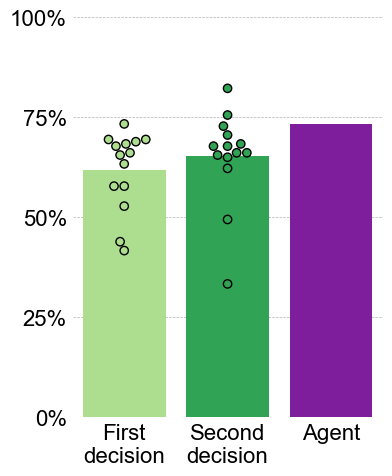

In [14]:
accuracy_first = [100*np.nanmean(all_correct_answers[s] == all_decisions[s]) for s in range(len(SUBJECTS))]
accuracy_final = [100*np.nanmean(all_correct_answers[s] == all_final_decisions[s]) for s in range(len(SUBJECTS))]
df = pd.DataFrame(np.vstack((accuracy_first+accuracy_final, [1]*len(SUBJECTS)+[2]*len(SUBJECTS))).T, 
                  columns=["Accuracy", "Decision"])
plt.figure(figsize=(4, 5))
sns.swarmplot(x="Decision", y="Accuracy", data=df, palette=['#addd8e', '#31a354'],
              edgecolor='k', linewidth=1, size=6)
accuracy_first = 100*np.mean(all_correct_answers[~np.isnan(all_correct_answers)] == all_decisions[~np.isnan(all_correct_answers)])
accuracy_final = 100*np.mean(all_correct_answers[~np.isnan(all_correct_answers)] == all_final_decisions[~np.isnan(all_correct_answers)])
plt.bar(0, accuracy_first, color="#addd8e", width=0.8)
plt.bar(1, accuracy_final, color="#31a354", width=0.8)
subject_with_all_sessions = [sum(np.isnan(all_correct_answers[s])) for s in range(len(SUBJECTS))].index(0)
agent_accuracy = 100*np.mean(all_agent_decisions == all_correct_answers[subject_with_all_sessions])
plt.bar(2, agent_accuracy, color="xkcd:purple", width=0.8) # 114f24
plt.ylim(0, 100)
plt.xlim(-0.5, 2.5)
plt.yticks(range(0, 101, 25), ["%d%%" % i for i in range(0, 101, 25)], fontsize=16)
plt.xticks(range(3), ["First\ndecision", "Second\ndecision", "Agent"], fontsize=16)
plt.xlabel("")
plt.ylabel("")
plt.savefig("%saccuracy.pdf" % RESULT_FOLDER, dpi=300)
plt.show()

## Response time

          W-val alternative     p-val       RBC     CLES
Wilcoxon   49.0   two-sided  0.855225 -0.066667  0.52551
-0.014271857933663605


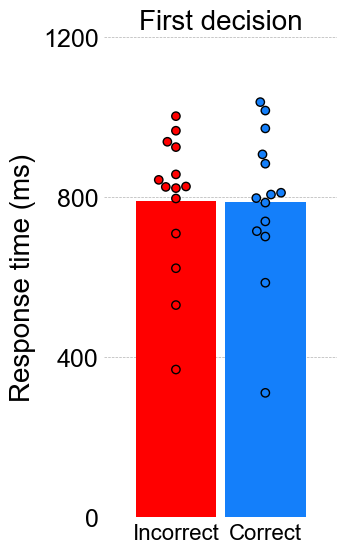

In [21]:
plt.figure(figsize=(3, 6))
correct = [np.nanmean(all_rts[s, all_decisions[s] == all_correct_answers[s]]) for s in range(len(SUBJECTS))]
incorrect = [np.nanmean(all_rts[s, all_decisions[s] != all_correct_answers[s]]) for s in range(len(SUBJECTS))]
print(pg.wilcoxon(correct, incorrect))
print(pg.compute_effsize(correct, incorrect))
df = pd.DataFrame(np.vstack((correct+incorrect, [1]*len(SUBJECTS)+[0]*len(SUBJECTS))).T, 
                  columns=["RT", "Accuracy"])
df.Accuracy = pd.to_numeric(df.Accuracy, downcast='integer')
sns.swarmplot(x="Accuracy", y="RT", data=df, palette=['#ff0000', '#147ffa'],
              edgecolor='k', linewidth=1, size=6, order=[1, 0])
plt.bar(1, np.mean(correct), color="#147ffa", width=0.9, label="Correct")
plt.bar(0, np.mean(incorrect), color="#ff0000", width=0.9, label="Incorrect")
plt.xticks([0, 1], ["Incorrect", "Correct"], ha="center", rotation=0, fontsize=16)
plt.yticks(range(0, 1201, 400), fontsize=18)
plt.xlabel("")
plt.xlim(-0.8, 1.8)
plt.ylim(0, 1200)
plt.title("First decision", fontsize=20)
plt.ylabel("Response time (ms)", fontsize=20)
plt.savefig("%sresponse_times_swarm_resp1.pdf" % RESULT_FOLDER, dpi=150)
plt.show()

          W-val alternative     p-val       RBC      CLES
Wilcoxon   35.0   two-sided  0.295776  0.333333  0.545918
0.23441685808562873


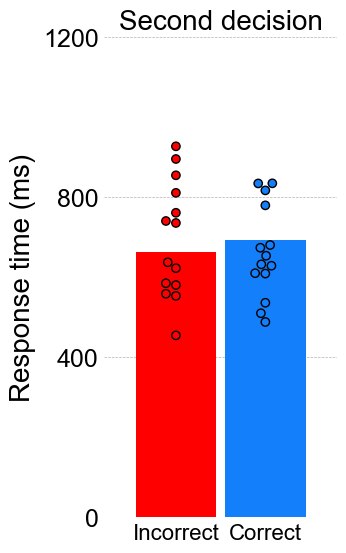

In [23]:
plt.figure(figsize=(3, 6))
correct = [np.nanmean(all_final_rts[s, all_final_decisions[s] == all_correct_answers[s]]) for s in range(len(SUBJECTS))]
incorrect = [np.nanmean(all_final_rts[s, all_final_decisions[s] != all_correct_answers[s]]) for s in range(len(SUBJECTS))]
print(pg.wilcoxon(correct, incorrect))
print(pg.compute_effsize(correct, incorrect))
df = pd.DataFrame(np.vstack((correct+incorrect, [1]*len(SUBJECTS)+[0]*len(SUBJECTS))).T, 
                  columns=["RT", "Accuracy"])
df.Accuracy = pd.to_numeric(df.Accuracy, downcast='integer')
sns.swarmplot(x="Accuracy", y="RT", data=df, palette=['#ff0000', '#147ffa'],
              edgecolor='k', linewidth=1, size=6, order=[1, 0])
plt.bar(0, np.mean(incorrect), color="#ff0000", width=0.9, label="Incorrect")
plt.bar(1, np.mean(correct), color="#147ffa", width=0.9, label="Correct")
plt.xticks([0, 1], ["Incorrect", "Correct"], ha="center", fontsize=16)
plt.yticks(range(0, 1201, 400), fontsize=18)
plt.xlim(-0.8, 1.8)
plt.ylim(0, 1200)
plt.xlabel("")
plt.title("Second decision", fontsize=20)
plt.ylabel("Response time (ms)", fontsize=20)
plt.savefig("%sresponse_times_swarm_resp2.pdf" % RESULT_FOLDER, dpi=150)
plt.show()

## RTs per confidence

FriedmanchisquareResult(statistic=11.142857142857139, pvalue=0.010977949666446215)


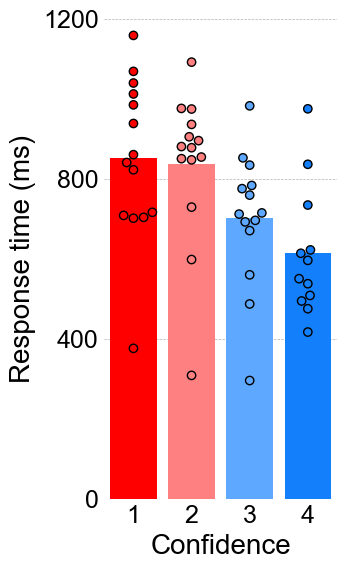

In [24]:
plt.figure(figsize=(3, 6))
rts_per_confidence = np.zeros((len(SUBJECTS), 4))
for c in range(1, 5):
    for s in range(len(SUBJECTS)):
        rts_per_confidence[s, c-1] = np.nanmean(all_rts[s, all_confidences[s] == c])
print(ss.friedmanchisquare(*rts_per_confidence.T))
plt.bar(range(0, 4), 
        np.nanmean(rts_per_confidence, axis=0), 
        color=['#ff0000', '#ff8080', '#5ea9ff', '#147ffa'], lw=3,
        #yerr=std_accuracies, 
        zorder=1)
df = pd.DataFrame(np.vstack((rts_per_confidence.flatten(), list(range(1, 5))*len(SUBJECTS), [s for s in range(len(SUBJECTS)) for i in range(4)])).T, columns=["Response Time", "Confidence", "Subject"])
sns.swarmplot(x="Confidence", y="Response Time", data=df, palette=['#ff0000', '#ff8080', '#5ea9ff', '#147ffa'],
              edgecolor='k', linewidth=1, size=6)
plt.ylim(0, 1200)
plt.xlim(-0.5, 3.5)
plt.yticks(range(0, 1201, 400), fontsize=18)
plt.xticks(range(4), range(1, 5), fontsize=18)
plt.xlabel("Confidence", fontsize=20)
plt.ylabel("Response time (ms)", fontsize=20)
plt.savefig("%srts_per_confidence.pdf" % RESULT_FOLDER, dpi=200)
plt.show()

## Accuracy per confidence

26.314285714285717 8.196216632185624e-06
          Source      W  ddof1     Q     p-unc
Friedman  Within  0.575      3  20.7  0.000122


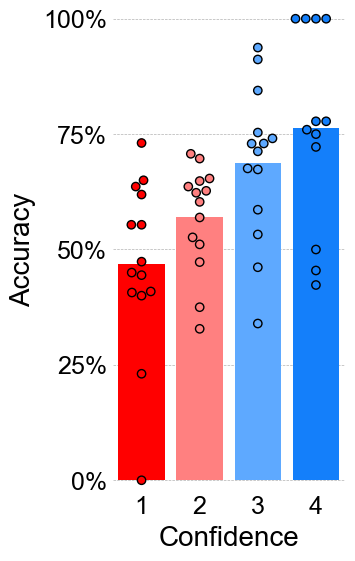

In [25]:
plt.figure(figsize=(3, 6))
mean_accuracies = []
std_accuracies = []
all_accuracies = np.zeros((len(SUBJECTS), 4))
for c in range(1, 5):
    all_trials = all_confidences == c
    correct_trials = np.logical_and(all_decisions == all_correct_answers, all_confidences == c)
    all_accuracies[:, c-1] = np.sum(correct_trials, axis=1) / np.sum(all_trials, axis=1)
    mean_accuracies.append(100*np.nanmean(np.sum(correct_trials, axis=1) / np.sum(all_trials, axis=1)))
    std_accuracies.append(100*ss.sem(np.sum(correct_trials, axis=1) / np.sum(all_trials, axis=1), nan_policy='omit'))
w, p = ss.friedmanchisquare(*all_accuracies.T)
print(w, p)
print(pg.friedman(data=pd.DataFrame(all_accuracies)))
plt.bar(range(0, 4), 
        mean_accuracies, 
        color=['#ff0000', '#ff8080', '#5ea9ff', '#147ffa'], lw=3,
        #yerr=std_accuracies, 
        zorder=1)
df = pd.DataFrame(np.vstack((100*all_accuracies.flatten(), list(range(1, 5))*len(SUBJECTS))).T, columns=["Accuracy", "Confidence"])
sns.swarmplot(x="Confidence", y="Accuracy", data=df, palette=['#ff0000', '#ff8080', '#5ea9ff', '#147ffa'],
              edgecolor='k', linewidth=1, size=6)
#     plt.scatter([conf]*len(SUBJECTS), 100*all_accuracies[:, conf-1], color=color, zorder=2, s=20, edgecolor='k')
plt.ylim(-2, 102)
plt.xlim(-0.5, 3.5)
plt.yticks(range(0, 101, 25), ["%d%%" % i for i in range(0, 101, 25)], fontsize=18)
plt.xticks(range(4), range(1, 5), fontsize=18)
plt.xlabel("Confidence", fontsize=20)
plt.ylabel("Accuracy", fontsize=20)
plt.savefig("%saccuracy_per_confidence.pdf" % RESULT_FOLDER, dpi=150)
plt.show()

### AUROC2

In [26]:
aucs = []
for s in range(len(SUBJECTS)):
    aucs.append(roc_auc_score(all_correct_answers[s] == all_decisions[s], all_confidences[s]))
    print("%.3f" % aucs[-1])
print(np.mean(aucs), np.std(aucs))
print(pg.ttest(aucs, 0.5))

0.590
0.683
0.553
0.596
0.554
0.646
0.696
0.422
0.565
0.554
0.585
0.598
0.480
0.619
0.5815434918254491 0.06965952791717174
               T  dof alternative  p-val         CI95%   cohen-d    BF10  \
T-test  4.220661   13   two-sided  0.001  [0.54, 0.62]  1.128019  39.152   

           power  
T-test  0.973346  


## Agent confidence

LinregressResult(slope=11.180472513614898, intercept=44.08005441982027, rvalue=0.9181028321959681, pvalue=0.0818971678040319, stderr=3.41290514561392, intercept_stderr=9.346625674390989)


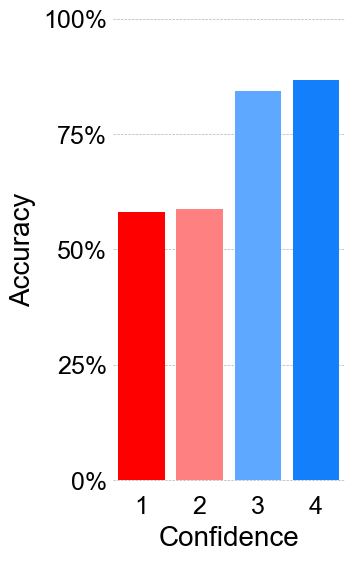

In [27]:
plt.figure(figsize=(3, 6))
all_accuracies = np.zeros((4, ))
mean_accuracies = []
for c in range(1, 5):
    mean_accuracies.append(100*np.mean(all_agent_decisions[all_agent_confidences == c] == all_correct_answers[0, all_agent_confidences == c]))
plt.bar(range(0, 4), 
        mean_accuracies, 
        color=['#ff0000', '#ff8080', '#5ea9ff', '#147ffa'], lw=3,
        zorder=1)
print(ss.linregress(list(range(1, 5)), mean_accuracies))
plt.ylim(-2, 102)
plt.xlim(-0.5, 3.5)
plt.yticks(range(0, 101, 25), ["%d%%" % i for i in range(0, 101, 25)], fontsize=18)
plt.xticks(range(4), range(1, 5), fontsize=18)
plt.xlabel("Confidence", fontsize=20)
plt.ylabel("Accuracy", fontsize=20)
plt.savefig("%saccuracy_per_confidence_agent.pdf" % RESULT_FOLDER, dpi=150)
plt.show()

# Accuracy per block

FriedmanchisquareResult(statistic=12.896405919661687, pvalue=0.0243691401419899)
FriedmanchisquareResult(statistic=22.037037037037003, pvalue=0.0005151775579238857)


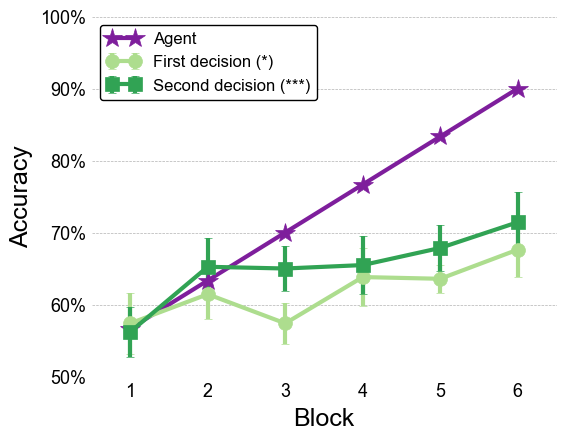

In [28]:
plt.figure(figsize=(6, 4.5))
accuracies = np.zeros((len(SUBJECTS), MAX_SESSIONS))
accuracies_final = np.zeros((len(SUBJECTS), MAX_SESSIONS))
for s in range(len(SUBJECTS)):
    for session in range(MAX_SESSIONS):
        beg = session*TRIALS_PER_SESSION
        end = (session+1)*TRIALS_PER_SESSION
        if np.isnan(all_correct_answers[s, beg]):
            continue
        accuracies[s, session] = dm_utils.accuracy(all_correct_answers[s, beg:end], 
                                                   all_decisions[s, beg:end])
        accuracies_final[s, session] = dm_utils.accuracy(all_correct_answers[s, beg:end], 
                                                         all_final_decisions[s, beg:end])
plt.errorbar(range(MAX_SESSIONS), np.mean(accuracies, axis=0), fmt="o-", color="#addd8e", label="First decision (*)", 
             yerr=ss.sem(accuracies, axis=0), lw=3)
print(ss.friedmanchisquare(*accuracies.T))
plt.errorbar(range(MAX_SESSIONS), np.mean(accuracies_final, axis=0), fmt="s-", color="#31a354", label="Second decision (***)", 
             yerr=ss.sem(accuracies_final, axis=0), lw=3)
print(ss.friedmanchisquare(*accuracies_final.T))
# Agent
subject_with_all_sessions = [sum(np.isnan(all_correct_answers[s])) for s in range(len(SUBJECTS))].index(0)
accuracy = []
for session in range(MAX_SESSIONS):
    beg = session*TRIALS_PER_SESSION
    end = (session+1)*TRIALS_PER_SESSION
    accuracy.append(dm_utils.accuracy(all_correct_answers[subject_with_all_sessions, beg:end], 
                                      all_agent_decisions[beg:end]))
plt.plot(accuracy, "*-", color="xkcd:purple", label="Agent", ms=15)
plt.xlim(-0.5, MAX_SESSIONS-0.5)
plt.xticks(range(MAX_SESSIONS), range(1, MAX_SESSIONS+1))
plt.yticks(range(0, 101, 10), ["%d%%" % i for i in range(0, 101, 10)])
plt.ylim(50, 100)
plt.xlabel("Block", fontsize=18)
plt.legend(loc="upper left")
plt.ylabel("Accuracy", fontsize=18)
plt.savefig("%saccuracy_over_blocks.pdf" % RESULT_FOLDER, dpi=150)
plt.show()

# Reported trust in artificial agent

FriedmanchisquareResult(statistic=3.607843137254846, pvalue=0.6071360659960869)
          Source         W  ddof1         Q     p-unc
Friedman  Within  0.051541      5  3.607843  0.607136


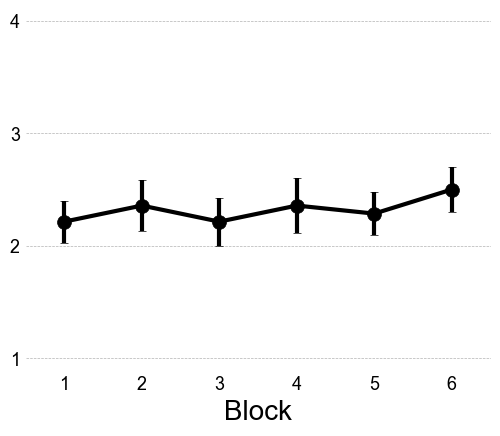

In [29]:
plt.figure(figsize=(6, 4.5))
plt.errorbar(range(MAX_SESSIONS), np.nanmean(trust_over_sessions, axis=0), fmt="o-", color="k", 
             yerr=ss.sem(trust_over_sessions, axis=0))
print(ss.friedmanchisquare(*trust_over_sessions.T))
print(pg.friedman(pd.DataFrame(trust_over_sessions)))
plt.xticks(range(MAX_SESSIONS), range(1, MAX_SESSIONS+1))
plt.ylim(0.9, 4.1)
plt.xlim(-0.5, MAX_SESSIONS-0.5)
plt.yticks(range(1, 5))
plt.xlabel("Block", fontsize=20)
plt.savefig("%sreported_trust_per_block.pdf" % RESULT_FOLDER, dpi=150)
plt.show()

# Change-of-mind-based measure of trust (Fig. 5B)

          Source         W  ddof1         Q     p-unc
Friedman  Within  0.051541      5  3.607843  0.607136
          Source         W  ddof1          Q     p-unc
Friedman  Within  0.417197      5  29.203822  0.000021
           n         r         CI95%     p-val     power
spearman  84  0.451604  [0.26, 0.61]  0.000016  0.992724
1.0643911113043745


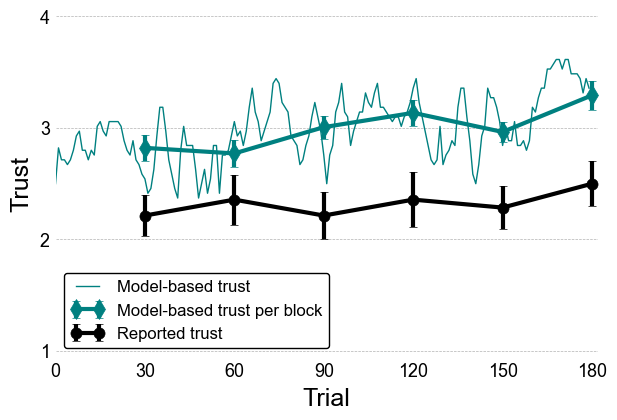

In [31]:
def is_trust(decision, confidence, final_decision, agent_decision, agent_confidence):
    if decision == -1 or final_decision == -1:
        return False
    if decision == agent_decision and decision == final_decision:
        return True
    if decision != agent_decision and decision != final_decision:
        return True
    return False

def is_distrust(decision, confidence, final_decision, agent_decision, agent_confidence):
    if decision == -1 or final_decision == -1:
        return False
    if decision == agent_decision and decision != final_decision:
        return True
    if decision != agent_decision and decision == final_decision:
        return True
    return False

trust = np.zeros((len(SUBJECTS), all_decisions.shape[1]))
for s in range(len(SUBJECTS)):
    for t in range(all_decisions.shape[1]):
        if is_trust(all_decisions[s, t], all_confidences[s, t], all_final_decisions[s, t], all_agent_decisions[t], all_agent_confidences[t]):
            trust[s, t] = 4
        elif is_distrust(all_decisions[s, t], all_confidences[s, t], all_final_decisions[s, t], all_agent_decisions[t], all_agent_confidences[t]):    
            trust[s, t] = 1
        elif trust[s, t-1]:
            trust[s, t] = trust[s, t-1]
        else:
            trust[s, t] = 1
N = 5
mean = pd.Series(np.nanmean(trust, axis=0)).rolling(N, min_periods=1).mean().values
plt.plot(mean, c='#008080', label="Model-based trust", lw=1)
mean_per_block = np.array([np.nanmean(trust[:, i:i+30], axis=1) for i in range(0, 180, 30)]).T
print(pg.friedman(pd.DataFrame(trust_over_sessions)))
print(pg.friedman(pd.DataFrame(mean_per_block)))
ci = ss.sem(mean_per_block, axis=0, nan_policy='omit')
plt.errorbar(range(30, 181, 30), np.nanmean(mean_per_block, axis=0), yerr=ci, color="#008080", marker="d", 
             ls="-", ms=10, label="Model-based trust per block")
ci = ss.sem(trust_over_sessions, axis=0, nan_policy='omit')
print(pg.corr(mean_per_block.flatten(), trust_over_sessions.flatten(), method='spearman'))
print(pg.compute_effsize(mean_per_block.flatten(), trust_over_sessions.flatten()))
plt.errorbar(range(30, 181, 30), np.nanmean(trust_over_sessions, axis=0), yerr=ci, color='k', marker="o", ls="-", ms=8, label="Reported trust")
plt.yticks(range(1, 5, 1))
plt.ylim(0.95, 4.05)
plt.xlim(0, 182)
plt.xticks(range(0, 181, 30))
plt.ylabel("Trust", fontsize=18)
plt.xlabel("Trial", fontsize=18)
plt.legend(loc='best')
plt.tight_layout#1b9e77)
plt.savefig("%strust_comparison.pdf" % (RESULT_FOLDER), dpi=150)
plt.show()